In [1]:
# pip install SimpleITK
# pip install nibabel

In [2]:
import SimpleITK as sitk
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import nibabel as nib
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [3]:
%run utils.ipynb

# Visualizing one image

In [4]:
image = sitk.ReadImage("../picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory KIM
# image = sitk.ReadImage("../data/picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory EMILIA

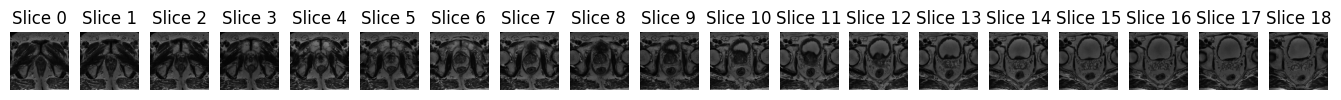

In [5]:
#this is to display the image
image_array = sitk.GetArrayFromImage(image)

# Display slices of the image using Matplotlib
num_slices = image_array.shape[0]  # Assuming the first dimension is the number of slices
fig, axes = plt.subplots(1, num_slices, figsize=(17, 4))
for i in range(num_slices):
    axes[i].imshow(image_array[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Slice {i}")
plt.show()

# Merging images with label in one dictionary

In [6]:
directory = "/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1"
# directory = "../data/picai_public_images_fold1" // EMILIA

In [7]:
##### ADD A KEY FOR AGE 
dict_images = {}

for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder) # /Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10010/10010_1000010
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if "t2w" in file_name and file_name.endswith('.mha'):
                full_path = os.path.join(directory, folder, file_name)
                if os.path.exists(full_path):
                    short_name = '_'.join(file_name.split('_')[:2])
                    image = sitk.ReadImage(full_path)
                    dict_images[short_name] = {'image': image, 'case_pca': None, 'patient_age': None, 'patient_id': None}

In [8]:
dict_images['10010_1000010']

{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x37892e910> >,
 'case_pca': None,
 'patient_age': None,
 'patient_id': None}

In [9]:
#size of the dictionary
len(dict_images)

298

We stored 3 things: 
* the nii files that have the color coded images 
* the labels for each image (from csv file)
* the age of patients for each image (from csv file)

# Opening nii files

In [10]:
# path = '../10035_1000035.nii'


In [11]:
# img = nib.load(path).get_fdata()
# img.shape

In [12]:
# print(f"The .nii files are stored in memory as numpy's: {type(img)}.")


In [13]:
# plt.style.use('default')
# fig, axes = plt.subplots(4,4, figsize=(12,12))
# for i, ax in enumerate(axes.reshape(-1)):
#     ax.imshow(img[:,:,1 + i])
# plt.show()

# Using the CSV file to get the labels and patients' age

In this spreadsheet, there is a column "lesion_GS", which lists the outcomes:

Gleason score (GS) assigned to each lesion after histopathologic analysis, where scores for different lesions are separated by , (commas). If its value is missing, then no tissue sampling procedure was performed; indicating a negative MRI study. If its value is N/A only for specific lesion(s), then those lesion(s) (as observed in radiology) were not biopsied or graded in histopathology (typically the case for PI-RADS 1-2 lesions).

This means that any case that contains a Gleason score of 7 (3+4 or higher) harbors csPCa, while all other cases are considered negative for csPCa. For more details on how this ground truth was derived, you can also check out our study design.


In [14]:
labels_path = "../marksheet.csv"
# labels_path = "../data/marksheet.csv"

In [15]:
df = pd.read_csv(labels_path)

In [16]:
df.head(100)

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
95,10095,1000095,2017-02-09,65,9.20,NaN,60.0,MRBx,0+0,0,0,NO
96,10096,1000096,2011-12-31,64,22.33,0.66,34.0,MRBx,0+0,0,0,NO
97,10097,1000097,2018-11-27,66,15.01,NaN,32.0,MRBx,3+4,2,2,YES
98,10098,1000098,2012-03-29,69,12.00,0.17,69.0,NaN,NaN,NaN,0,NO


### Evaluating class imbalance

In [17]:
df['case_csPCa'].value_counts()

NO     1075
YES     425
Name: case_csPCa, dtype: int64

Combining them both

## Combining patient_id and study_id to get the full differentiator per patient

In [18]:
df['full_name'] = df['patient_id'].astype(str) + '_' + df['study_id'].astype(str)

In [19]:
df

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,full_name
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO,10000_1000000
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO,10001_1000001
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO,10002_1000002
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO,10003_1000003
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO,10004_1000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,YES,11471_1001495
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,YES,11472_1001496
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,NO,11473_1001497
1498,11474,1001498,2016-05-03,71,12.00,NaN,83.0,MRBx,3+3,1,1,NO,11474_1001498


### Testing

In [20]:
specific_full_name = '10000_1000000'
case_csPCA_value = df.loc[df['full_name'] == specific_full_name, 'case_csPCa'].iloc[0]
case_csPCA_value

'NO'

## Adding to a dictionary based on their full name

In [21]:
not_found = 0
found = 0

for f in df['full_name']:
    if f in dict_images:
        print(f"Found {f}")
        case_csPCa_value = df.loc[df['full_name'] == f, 'case_csPCa'].iloc[0]
        patient_age = df.loc[df['full_name'] == f, 'patient_age'].iloc[0]
        #converting to 0 and 1
        dict_images[f]['case_pca'] = 0 if case_csPCa_value == 'NO' else 1 if case_csPCa_value == 'YES' else None
        dict_images[f]['patient_age'] = patient_age
        dict_images[f]['patient_id'] = f

        found += 1
    else:
        print(f"Could not find {f}")
        not_found += 1

Could not find 10000_1000000
Could not find 10001_1000001
Could not find 10002_1000002
Could not find 10003_1000003
Could not find 10004_1000004
Could not find 10005_1000005
Could not find 10006_1000006
Could not find 10007_1000007
Found 10008_1000008
Could not find 10009_1000009
Found 10010_1000010
Found 10011_1000011
Could not find 10012_1000012
Could not find 10013_1000013
Could not find 10014_1000014
Could not find 10015_1000015
Found 10016_1000016
Could not find 10017_1000017
Could not find 10018_1000018
Found 10019_1000019
Could not find 10020_1000020
Could not find 10021_1000021
Could not find 10022_1000022
Could not find 10023_1000023
Found 10024_1000024
Could not find 10025_1000025
Found 10026_1000026
Could not find 10027_1000027
Could not find 10028_1000028
Could not find 10029_1000029
Could not find 10030_1000030
Found 10031_1000031
Could not find 10032_1000032
Could not find 10033_1000033
Could not find 10034_1000034
Could not find 10035_1000035
Found 10036_1000036
Could no

In [22]:
found, not_found

(298, 1202)

In [23]:
dict_images

{'10268_1000272': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x1048c2670> >,
  'case_pca': 1,
  'patient_age': 76,
  'patient_id': '10268_1000272'},
 '10892_1000908': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x1048c1dd0> >,
  'case_pca': 0,
  'patient_age': 64,
  'patient_id': '10892_1000908'},
 '11385_1001409': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x1048c0870> >,
  'case_pca': 1,
  'patient_age': 75,
  'patient_id': '11385_1001409'},
 '10401_1000407': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x3764cee20> >,
  'case_pca': 0,
  'patient_age': 63,
  'patient_id': '10401_1000407'},
 '11371_1001394': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x3764ccab0> >,
  'case_pca': 0,
  'patient_age': 52,
  'patient_id': '11371_1001394'},


### Evaluating class imbalance in final sample

In [24]:
# Extract 'case_pca' values from dictionary values
case_pca_values = [item['case_pca'] for item in dict_images.values()]

# Count occurrences of 'YES' and 'NO'
counts = Counter(case_pca_values)
yes_count = counts[1]
no_count = counts[0]

print(f"Count of 'YES': {yes_count}")
print(f"Count of 'NO': {no_count}")

Count of 'YES': 77
Count of 'NO': 221


In [25]:
#our dictionary with the T2w images and the case_csPCa values
dict_images

{'10268_1000272': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x1048c2670> >,
  'case_pca': 1,
  'patient_age': 76,
  'patient_id': '10268_1000272'},
 '10892_1000908': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x1048c1dd0> >,
  'case_pca': 0,
  'patient_age': 64,
  'patient_id': '10892_1000908'},
 '11385_1001409': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x1048c0870> >,
  'case_pca': 1,
  'patient_age': 75,
  'patient_id': '11385_1001409'},
 '10401_1000407': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x3764cee20> >,
  'case_pca': 0,
  'patient_age': 63,
  'patient_id': '10401_1000407'},
 '11371_1001394': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x3764ccab0> >,
  'case_pca': 0,
  'patient_age': 52,
  'patient_id': '11371_1001394'},


In [26]:
dict_images['10010_1000010']

{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x37892e910> >,
 'case_pca': 0,
 'patient_age': 67,
 'patient_id': '10010_1000010'}

# Image Preprocessing

In [27]:
## Images
images = [forresnet(entry['image']) for entry in dict_images.values()]

Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (640, 640)
Shape after adding dimension: (640, 640, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (1024, 1024)
Shape after adding dimension: (1024, 1024, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacki

Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (640, 640)
Shape after adding dimension: (640, 640, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (640, 640)
Shape after adding dimension: (640, 640, 1)
Resized shape: (224, 224, 1)
Shape after squ

# Train Test Split

In [28]:
labels = [entry['case_pca'] for entry in dict_images.values()]
ages = [entry['patient_age'] for entry in dict_images.values()]

X_train, X_test, y_train, y_test, age_train, age_test = train_test_split(images, labels, ages, test_size=0.2, random_state = 42)

#split for validations sets
X_train, X_val, y_train, y_val, age_train, age_val = train_test_split(X_train, y_train, age_train, test_size=0.2, random_state = 42)


X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
age_train = np.array(age_train)
age_val = np.array(age_val)
age_test = np.array(age_test)

### Evaluating class imbalance in train, test, and validation sets

In [29]:
# Count labels in X_train
train_label_counts = Counter(y_train)
print("Train Label Counts:", train_label_counts)

# Count labels in X_val
val_label_counts = Counter(y_val)
print("Validation Label Counts:", val_label_counts)

# Count labels in X_test
test_label_counts = Counter(y_test)
print("Test Label Counts:", test_label_counts)


Train Label Counts: Counter({0: 142, 1: 48})
Validation Label Counts: Counter({0: 37, 1: 11})
Test Label Counts: Counter({0: 42, 1: 18})


In [30]:
X_train.shape, X_val.shape, X_test.shape

((190, 224, 224, 3), (48, 224, 224, 3), (60, 224, 224, 3))

# Baseline Model: ResNet50

In [31]:
# model = tf.keras.applications.ResNet50()

In [32]:
# Load pre-trained ResNet-50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dense(128, activation='relu')(x)  # Add a dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

# Combine the base model and new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [33]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
6/6 [==============================] - 6s 825ms/step - loss: 0.7688 - accuracy: 0.6526 - val_loss: 0.5331 - val_accuracy: 0.7708
Epoch 2/10
6/6 [==============================] - 4s 752ms/step - loss: 0.6172 - accuracy: 0.7000 - val_loss: 0.5550 - val_accuracy: 0.7708
Epoch 3/10
6/6 [==============================] - 4s 754ms/step - loss: 0.5453 - accuracy: 0.7474 - val_loss: 0.5398 - val_accuracy: 0.7708
Epoch 4/10
6/6 [==============================] - 4s 748ms/step - loss: 0.5498 - accuracy: 0.7474 - val_loss: 0.5132 - val_accuracy: 0.7708
Epoch 5/10
6/6 [==============================] - 4s 760ms/step - loss: 0.5228 - accuracy: 0.7526 - val_loss: 0.5227 - val_accuracy: 0.7708
Epoch 6/10
6/6 [==============================] - 4s 744ms/step - loss: 0.5090 - accuracy: 0.7474 - val_loss: 0.4973 - val_accuracy: 0.7708
Epoch 7/10
6/6 [==============================] - 4s 750ms/step - loss: 0.4961 - accuracy: 0.7474 - val_loss: 0.4936 - val_accuracy: 0.7708
Epoch 8/10
6/6 [====

In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2/2 [==============================] - 1s 518ms/step - loss: 0.6181 - accuracy: 0.7000
Test accuracy: 0.699999988079071


## Performance Evaluation

2/2 [==============================] - 1s 529ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.768421,1.0,0.083333,0.153846
Validation,0.791667,1.0,0.090909,0.166667
Test,0.700000,0.0,0.000000,0.000000


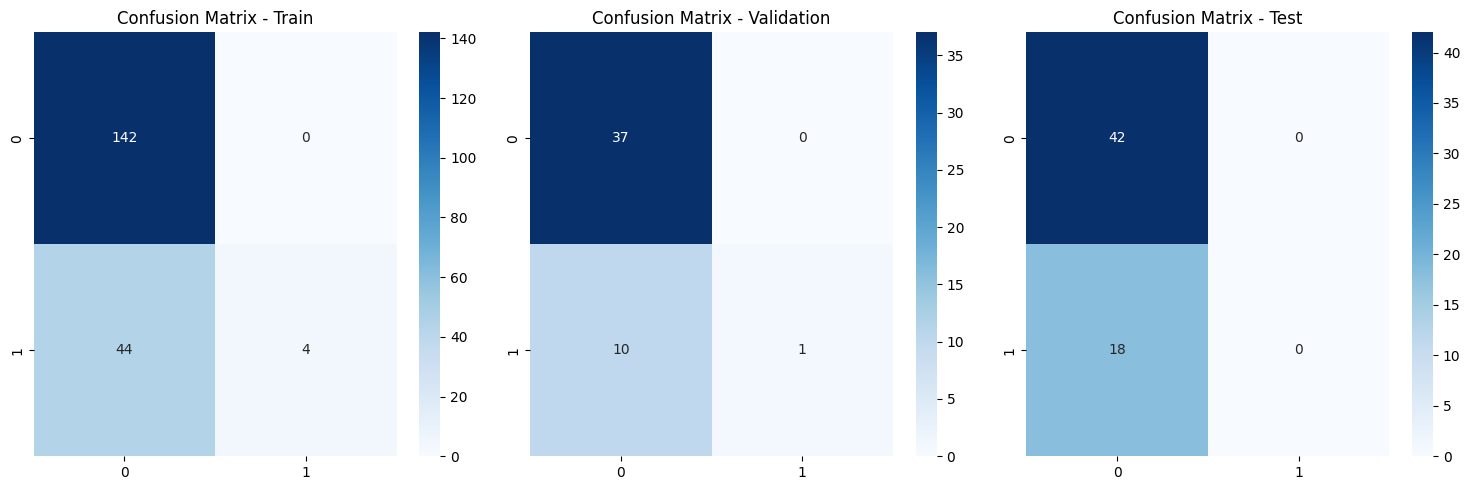

In [36]:
metrics_df = evaluate_model(model, 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

# Experiment 3: Multimodal Model

To follow the same type of model they did in the paper "Indication as Prior Knowledge for Multimodal Disease Classification in Chest Radiographs with Transformers" I decided to use the MMF package of Facebook

In [37]:
!rustup install stable


info: syncing channel updates for 'stable-aarch64-apple-darwin'

  stable-aarch64-apple-darwin unchanged - rustc 1.78.0 (9b00956e5 2024-04-29)

info: checking for self-update


In [35]:
# !pip cache purge
# !curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh



In [36]:
# pip install git+https://github.com/facebookresearch/mmf.git

In [37]:
# !pytest ./tests/

### this test is supposed to pass but it is not working


## Preprocessing Tabular data post train-test split (normalizing age)

In [40]:
scaler = StandardScaler()

#train
standardized_train_age = scaler.fit_transform(age_train.reshape(-1,1))

#test
standardized_val_age = scaler.transform(age_val.reshape(-1, 1))
standardized_test_age = scaler.transform(age_test.reshape(-1, 1))

#converting the standardized age data back to 1D arrays
age_train_normalized = standardized_train_age.flatten()
age_test_normalized = standardized_test_age.flatten()
age_val_normalized = standardized_val_age.flatten()

In [41]:
### trying to replicate smt like:
# -*- coding: utf-8 -*-
#
# Copyright (C) 2022 Grzegorz Jacenków.
#
# Licensed under the Apache License, Version 2.0 (the "License"); you may not
# use this file except in compliance with the License. You may obtain a copy of
# the License at http://www.apache.org/licenses/LICENSE-2.0.
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
# WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
# License for the specific language governing permissions and limitations under
# the License.

"""Multimodal (image and text) approach taken from:

Towards Automated Diagnosis with Attentive Multi-modal Learning Using Electronic
Health Records and Chest X-Rays by (van Sonsbeek and Worring, 2020).

We tried to recreate the approach to the best of our knowledge following the
publication. Unfortunately, we were not able to run the official code.
"""

from mmf.common.registry import registry
from mmf.models import BaseModel
from mmf.modules.encoders import build_image_encoder
from mmf.modules.embeddings import BiLSTMTextEmbedding
from mmf.utils.build import build_classifier_layer
import torch
import torch.nn.functional as F
from torchnlp.nn import Attention


@registry.register_model("attentive")
class AttentiveMultimodal(BaseModel):
    def __init__(self, config):
        super().__init__(config)
        self.build()

    @classmethod
    def config_path(cls):
        return "chest_multimodal/configs/models/attentive/defaults.yaml"

    def build(self):
        """ResNet50 with GRU and two attention blocks."""
        self.attention_a = Attention(self.config.attention.dimension)
        self.attention_b = Attention(self.config.attention.dimension)
        self.classifier = build_classifier_layer(self.config.classifier)
        self.image_encoder = build_image_encoder(self.config.image_encoder)
        self.text_embedding = self.build_text_embedding()

    def build_text_embedding(self):
        module_config = self.config.text_embedding

        return BiLSTMTextEmbedding(
            module_config.num_hidden,
            module_config.embedding_size,
            module_config.num_layers,
            module_config.dropout,
            module_config.bidirectional,
            module_config.rnn_type,
        )

    def forward(self, sample_list):
        image_features = self.image_encoder(sample_list['image'])
        text_features = self.text_embedding(sample_list['text'])[:, None, :]

        # Attention.
        image_attention, _ = self.attention_a(image_features, text_features)
        text_attention, _ = self.attention_b(text_features, image_features)

        image_features = F.relu(image_features + image_attention)
        text_features = F.relu(text_features + text_attention)

        # Fusion. Concatenate channels and `max` over them.
        combined, _ = torch.max(
            torch.cat([image_features, text_features], 1), 1)

        # Classifier.
        logits = self.classifier(combined)

        return {"scores": logits}

ModuleNotFoundError: No module named 'mmf.common'

## tryng to replicate usoing torch libraries instead of MMF

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiLSTMTextEmbedding(nn.Module): 
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0, bidirectional=True):
        super(BiLSTMTextEmbedding, self).__init__()
        
        self.bidirectional = bidirectional # True if bidirectional, False otherwise
        self.num_directions = 2 if bidirectional else 1 # 2 if bidirectional, 1 otherwise
        self.num_layers = num_layers # Number of layers
        self.dropout = nn.Dropout(p=dropout) 
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size // self.num_directions,
                            num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)

    def forward(self, x):
        # Assuming x is a tensor of shape (batch_size, sequence_length, embedding_size)
        x = self.dropout(x)
        outputs, (hidden, _) = self.lstm(x)
        # Concatenate the hidden states from both directions
        if self.bidirectional:
            hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        return hidden


class AttentiveMultimodal(nn.Module):
    def __init__(self, config):
        super(AttentiveMultimodal, self).__init__()
        self.config = config
        self.attention_a = Attention(config.attention.dimension)
        self.attention_b = Attention(config.attention.dimension)
        self.classifier = nn.Linear(config.image_encoder.hidden_size + config.text_embedding.hidden_size, config.num_classes)
        self.image_encoder = nn.Identity()  # Placeholder for image encoder
        self.text_embedding = BiLSTMTextEmbedding(
            config.text_embedding.input_size,
            config.text_embedding.hidden_size,
            config.text_embedding.num_layers,
            config.text_embedding.dropout,
            config.text_embedding.bidirectional
        )

    def forward(self, image, text):
        image_features = self.image_encoder(image)
        text_features = self.text_embedding(text)

        # Attention
        image_attention, _ = self.attention_a(image_features, text_features.unsqueeze(1))
        text_attention, _ = self.attention_b(text_features.unsqueeze(1), image_features)

        image_features = F.relu(image_features + image_attention)
        text_features = F.relu(text_features + text_attention)

        # Fusion. Concatenate channels and `max` over them.
        combined, _ = torch.max(torch.cat([image_features, text_features], 1), 1)

        # Classifier
        logits = self.classifier(combined)
        return {"scores": logits}
